In [1]:
# prepare model 
# prepare benign images & adversarial images -> value range should be the same
# extract simple NIC model 

In [2]:
from MNIST_models import *
import PI

meta_params = {
    'num_of_train_dataset': 1000,
    'num_of_test_dataset': 1000,
    'is_flatten': False
}


PI = PI.PIInterface(meta_params)
model = load_model('store/MNIST_CNN.pt')
PI.set_model(model)
print('train acc:', PI.eval_model('train'))
print('test acc:', PI.eval_model('test'))

1000 1000
(1000, 1, 28, 28)


C:\Users\nmake\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'MNIST_models.CNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\nmake\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\nmake\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.M

train acc: 0.991
test acc: 0.974


In [3]:
import pickle
prefix = 'store/'    
# LOAD 
adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
set_of_train_dataset, set_of_test_dataset = [], []

for adv_type in adv_types:
    # extract from the store file 
    if adv_type == 'None': fn_name=prefix+'normal.txt'
    else: fn_name=prefix+adv_type+'.txt'
    fp = open(fn_name, 'rb')
    set_of_signatures = pickle.load(fp)
    
    # separate and store in for later training and evaluation 
    if adv_type == 'None': split_percentage = 0.8
    else: split_percentage = 0.8
    split_line = int(len(set_of_signatures)*split_percentage)
    train_set_of_signatures, test_set_of_signatures = set_of_signatures[:split_line], set_of_signatures[split_line:]
    set_of_train_dataset.append(train_set_of_signatures)
    set_of_test_dataset.append(test_set_of_signatures)
    fp.close()
#     set_of_signatures = np.array(set_of_signatures)
#     for i in range(4):
#         print(np.max(set_of_signatures[0][i][0]), np.min(set_of_signatures[0][i][0]))
    
    print(adv_type, len(set_of_signatures), len(train_set_of_signatures), len(test_set_of_signatures))

None 1000 800 200
FGSM 813 650 163
JSMA 966 772 194
CWL2 877 701 176
LINFPGD 978 782 196
LINFBI 970 776 194
ENL1 1000 800 200
ST 991 792 199


In [4]:
import torch
from torch.autograd import Variable

class NIC(nn.Module):
    def __init__(self):
        super(NIC, self).__init__()
        n = 16
        m = 2

        self.fc_compress_1 = nn.Linear(16*24*24, n)
        self.fc_compress_2 = nn.Linear(16*10*10, n)
        self.fc_compress_3 = nn.Linear(32*3*3, n)
        self.fc_compress_4 = nn.Linear(64, n)

        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        self.output = nn.Linear(n, m)
        
    def forward(self, x1, x2, x3, x4):
        x1 = x1.view(-1, 16*24*24)
        x2 = x2.view(-1, 16*10*10)
        x3 = x3.view(-1, 32*3*3)
        x4 = x4.view(-1, 64)
        
        x1 = self.relu(self.fc_compress_1(x1))
        x2 = self.relu(self.fc_compress_2(x2))
        x3 = self.relu(self.fc_compress_3(x3))
        x4 = self.relu(self.fc_compress_4(x4))
        
        x1 = self.dropout(x1)
        x2 = self.dropout(x2)
        x3 = self.dropout(x3)
        x4 = self.dropout(x4)

        s = torch.add(x1, x2)
        
        s = self.relu(s)
        s = self.dropout(s)
        
        s = torch.add(s, x3)
        
        s = self.relu(s)
        s = self.dropout(s)
        
        s = torch.add(s, x4)
        
        s = self.relu(s)
        s = self.dropout(s)
        
        s = self.relu(self.output(s))
        
        return self.softmax(s)
    
def test_guard_model(nic, set_of_test_dataset, adv_types, verbose=False):
    nic.eval()
    total_train_correct_count, total_train_count = 0, 0 
    for test_dataset, adv_type in zip(set_of_test_dataset, adv_types):
        current_count = 0
        for singatures in test_dataset:
            f1, f2, f3, f4 = preprocess(singatures)
            outputs = nic.forward(f1, f2, f3, f4)
            if adv_type == 'None': label = torch.from_numpy(np.array([[1, 0]])).float()
            else: label = torch.from_numpy(np.array([[0, 1]])).float()

            prediction = (outputs.max(1, keepdim=True)[1]).item()     
            if adv_type == 'None': 
                if (prediction == 0): 
                    current_count += 1
            else: 
                if (prediction == 1): 
                    current_count += 1
            
        # record the current train set acc
        if verbose:
            if adv_type == 'None': 
                print('benign correct:', current_count, '/', len(test_dataset))
            else:
                print('adv (', adv_type, ') correct:', current_count, '/', len(test_dataset))

        total_train_correct_count += current_count
        total_train_count += len(test_dataset)

    acc = total_train_correct_count/total_train_count
    if verbose:
        print('acc:', acc)
        
        
    nic.train()
    return acc
    
nic = NIC()
nic.train()
optimizer = torch.optim.Adam(nic.parameters())
loss_func = nn.BCELoss()
epoches = 0

train_accs, test_accs, losses = [], [], []
set_train_sub_accs, set_test_sub_accs = [], []

for epoch in range(epoches):
    total_loss = None 
    # labeling ...
    train_dataset, train_labels = [], []
    for dataset, adv_type in zip(set_of_train_dataset, adv_types):
        for singatures in dataset:
            if adv_type == 'None': 
                for _ in range(1):
                    train_dataset.append(singatures)
                    label = torch.from_numpy(np.array([[1, 0]])).float()
                    train_labels.append(label)

            else: 
                train_dataset.append(singatures)
                label = torch.from_numpy(np.array([[0, 1]])).float()
                train_labels.append(label)

    # shuffling 
    shuffle_indexs = np.arange(len(train_dataset))
    np.random.shuffle(shuffle_indexs)

    # training 
    for index in shuffle_indexs:
        singatures, label = train_dataset[index], train_labels[index]
        f1, f2, f3, f4 = preprocess(singatures)
        outputs = nic.forward(f1, f2, f3, f4)

        # for recording the training process 
        loss = loss_func(outputs, label) 
        if total_loss is None: total_loss = loss 
        else: total_loss += loss

        # Optimization (back-propogation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch:', (epoch+1), 'loss:', total_loss.item())    
    train_acc = test_guard_model(nic, set_of_train_dataset, adv_types, verbose=True)
    test_acc = test_guard_model(nic, set_of_test_dataset, adv_types, verbose=True)
    print('train (acc):', train_acc)
    print('test (acc):', test_acc)
    print()
    




In [5]:
# GENERATE & STORE
# adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
# for adv_type in adv_types:
#     if adv_type == 'None': 
#         set_of_signatures = PI.generate_signatures() 
#     else: 
#         fn_name='store/'+adv_type+'.txt'
#         set_of_signatures = PI.generate_signatures(adv_type=adv_type)

# LOAD
prefixs = ['store_zero/', 'store_one/', 'store_two/', 'store_three/', 'store_four/', 
        'store_five/', 'store_six/', 'store_seven/', 'store_eight/', 'store_nine/']    

one_to_nine_set_of_train_dataset = []
one_to_nine_set_of_test_dataset = []

for idx, prefix in enumerate(prefixs):
    fn = 'store_subs_fadv/'+prefix+'guard.pt'
    
    set_of_train_dataset = []
    set_of_test_dataset = []
    
    # LOAD DATASET 
    adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
    set_of_train_dataset, set_of_test_dataset = [], []
    for adv_type in adv_types:
        
        set_of_signatures = []
        for i in range(1000):
            # extract from the store file 
            if adv_type == 'None': fn_name = 'store_subs_fadv/'+prefix+'normal'+'_'+str(i+1)+'.txt'
            else: fn_name = 'store_subs_fadv/'+prefix+adv_type+'_'+str(i+1)+'.txt'
            try: 
                fp = open(fn_name, 'rb')
            except:
                continue
                
            signatures = pickle.load(fp)
            fp.close()
            set_of_signatures.append(signatures)

        # separate and store in for later training and evaluation 
        if adv_type == 'None': split_percentage = 0.8
        else: split_percentage = 0.8
        split_line = int(len(set_of_signatures)*split_percentage)
        
        train_set_of_signatures, test_set_of_signatures = set_of_signatures[:split_line], set_of_signatures[split_line:]
        set_of_train_dataset.append(train_set_of_signatures)
        set_of_test_dataset.append(test_set_of_signatures)
        # print(prefix, adv_type, len(set_of_signatures), len(train_set_of_signatures), len(test_set_of_signatures))
    
    one_to_nine_set_of_train_dataset.append(set_of_train_dataset)
    one_to_nine_set_of_test_dataset.append(set_of_test_dataset)    
    

In [6]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

# figsize = (12, 10)
# fig=plt.figure(figsize=figsize)

# adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
# for i in range(10):
#     fig.add_subplot(5, 2, i+1)
#     x = []
#     for adv_i, adv_type in enumerate(adv_types):
#         x.append(len(one_to_nine_set_of_train_dataset[i][adv_i]))
    
#     index = np.arange(len(x))
#     plt.bar(index, x, align='center', alpha=0.5)
#     plt.xticks(index, adv_types)
#     plt.title(i)
#     plt.ylim([0, 350])
#     plt.tight_layout()
    
# plt.savefig('adv_samples_dis_per_class.jpg')
# plt.show()

# prefixs = ['store_zero/', 'store_one/', 'store_two/', 'store_three/', 'store_four/', 
#         'store_five/', 'store_six/', 'store_seven/', 'store_eight/', 'store_nine/']  

# for idx, prefix in enumerate(prefixs):
#     if not (idx in [2, 4, 9]): continue
        
#     fn = 'store_subs_fadv/'+prefix+'nic.pt'
    
#     # LOAD DATASET 
#     set_of_train_dataset = one_to_nine_set_of_train_dataset[idx]
#     set_of_test_dataset = one_to_nine_set_of_test_dataset[idx]

#     #####################################################################
#     # TRAIN
#     #####################################################################
#     nic = NIC()
#     nic.train()
#     optimizer = torch.optim.Adam(nic.parameters(), lr=1e-4)
#     loss_func = nn.MSELoss()
#     epoches = 50

#     train_accs, test_accs, losses = [], [], []

#     for epoch in range(epoches):
#         total_loss = None 
#         # labeling ...
#         train_dataset, train_labels = [], []
#         for dataset, adv_type in zip(set_of_train_dataset, adv_types):
#             for singatures in dataset:
#                 if adv_type == 'None': 
#                     for _ in range(1):
#                         train_dataset.append(singatures)
#                         label = torch.from_numpy(np.array([[1, 0]])).float()
#                         train_labels.append(label)

#                 else: 
#                     train_dataset.append(singatures)
#                     label = torch.from_numpy(np.array([[0, 1]])).float()
#                     train_labels.append(label)

#         # shuffling 
#         shuffle_indexs = np.arange(len(train_dataset))
#         np.random.shuffle(shuffle_indexs)

#         # training 
#         for index in shuffle_indexs:
#             singatures, label = train_dataset[index], train_labels[index]
#             f1, f2, f3, f4 = preprocess(singatures)
#             outputs = nic.forward(f1, f2, f3, f4)

#             # for recording the training process 
#             loss = loss_func(outputs, label)
#             # print(round(loss.item(), 5), round(l1.item(), 5), round(l2.item(), 5))
#             if total_loss is None: total_loss = loss 
#             else: total_loss += loss

#             # Optimization (back-propogation)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # record training process 
#         print(fn)
#         print('epoch:', (epoch+1), 'loss:', total_loss.item())    
#         train_acc = test_guard_model(nic, set_of_train_dataset, adv_types, verbose=False)
#         test_acc = test_guard_model(nic, set_of_test_dataset, adv_types, verbose=False)
#         print('train (acc):', train_acc)
#         print('test (acc):', test_acc)
#         print()
        
        
#         train_accs.append(train_acc)
#         test_accs.append(test_acc)
#         losses.append(loss.item())
        
        
#     # plot the training process 
#     fig.add_subplot(2, 5, idx+1)
#     plt.plot(np.arange(len(losses)), losses/np.max(np.array(losses)))
#     plt.plot(np.arange(len(train_accs)), train_accs)
#     plt.plot(np.arange(len(test_accs)), test_accs)
#     plt.title(idx)
#     plt.ylim([0, 1.05])
#     plt.legend(['loss', 'train acc', 'test acc'], loc='lower left')
#     plt.tight_layout()
    
#     nic.eval()
#     torch.save(nic, fn)

# # plt.savefig('zero_to_nine_ONIC_train_process_2.jpg')
# # plt.show()

In [7]:
prefixs = ['store_zero/', 'store_one/', 'store_two/', 'store_three/', 'store_four/', 
           'store_five/', 'store_six/', 'store_seven/', 'store_eight/', 'store_nine/']     

# LOAD 
guards = []
for idx, prefix in enumerate(prefixs):
    # LOAD TRAINED SUB-GUARD
    guard_model = torch.load('store_subs_fadv/'+prefix+'nic.pt')
    guards.append(guard_model)
    
adv_types = ['None', 'FGSM', 'JSMA', 'CWL2', 'LINFPGD', 'LINFBI', 'ENL1', 'ST']
accs = []
for adv_type in adv_types:
    print(adv_type)
    if adv_type == 'None':
        acc = PI.eval_sub_guards(guards)
        accs.append(acc)        
    else:
        acc = PI.eval_sub_guards(guards, adv_type)
        accs.append(acc)

None


C:\Users\nmake\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


correct_count: 825 total_count: 974
acc: 0.8470225872689938
0.8470225872689938
FGSM
correct_count: 816 total_count: 816
acc: 1.0
1.0
JSMA
correct_count: 970 total_count: 973
acc: 0.9969167523124358
0.9969167523124358
CWL2
correct_count: 850 total_count: 860
acc: 0.9883720930232558
0.9883720930232558
LINFPGD
correct_count: 967 total_count: 973
acc: 0.9938335046248715
0.9938335046248715
LINFBI
correct_count: 941 total_count: 957
acc: 0.9832810867293625
0.9832810867293625
ENL1
correct_count: 990 total_count: 1000
acc: 0.99
0.99
ST
correct_count: 874 total_count: 882
acc: 0.9909297052154195
0.9909297052154195


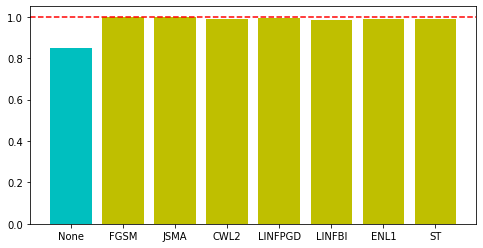

In [44]:
figsize = (8, 4)
fig=plt.figure(figsize=figsize)
x = accs
index = np.arange(len(x))
plt.bar(index, x, align='center', color='cyyyyyyy')
plt.xticks(index, adv_types)
plt.ylim([0, 1.05])

plt.axhline(y=1.0, color='r', linestyle='--')
plt.savefig('eval_assemble_ONIC.jpg')
    